<a href="https://colab.research.google.com/github/bhatiavr/cs109b-final-project-111/blob/master/Raghu_PB_cs109b_wastewater_covid_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import 

In [ ]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/"My Drive"/ColabHome/2021_109B/Final_Project/src/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/ColabHome/2021_109B/Final_Project/src


In [ ]:
# Load useful libraries
import numpy as np
import pandas as pd
import os
import tqdm
import pathlib
import time
import pickle
import seaborn as sns
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, \
                            TimeDistributed, GRU, LSTM, Dropout, Bidirectional, \
                            Conv1D, BatchNormalization
from tensorflow.keras.optimizers import SGD

# Plotting libraries
from matplotlib import pyplot as plt
%matplotlib inline

#Utility Function

In [95]:
from tensorflow.keras import backend
import tensorflow as tf
import sklearn
#from sklearn.metrics import mean_absolute_percentage_error

In [130]:
def deco_run_store_plot_validation(func):    
    def wrap_deco_run_store_plot_validation(*args):
        model_name = args[0]
        y_true = args[1]
        y_pred = args[2]
        # temp = np.asarray(train_y).astype(np.float32)
        # predictions = np.asarray(train_y).astype(np.float32)
        result_list = []
        results=[]
        val = func(model_name,y_true, y_pred)
        results.append(model_name)
        results.append(time.strftime('%Y:%m:%d'))
        results.append(func.__name__)
        results.append(tf.keras.backend.get_value(val))
        print(val)
        result_list.append(results)
        with open('validation_results.csv','ab')as fp:
            np.savetxt(fp,  result_list,delimiter=',',fmt='% s',newline='\n')

    return wrap_deco_run_store_plot_validation 

In [131]:

# Calculate RMSE
@deco_run_store_plot_validation
def rmse_calc(model_name,y_true,y_pred):
    return sklearn.metrics.mean_squared_error(y_true,y_pred)



In [132]:
# MAE 
@deco_run_store_plot_validation
def mae_calc(model_name,y_true,y_pred):
    return sklearn.metrics.mean_absolute_error(y_true,y_pred)


In [133]:
# MAPE 
@deco_run_store_plot_validation
def mape_calc(model_name,y_true,y_pred):
    return sklearn.metrics.mean_absolute_percentage_error(y_true,y_pred)

In [134]:
@deco_run_store_plot_validation
def corr_calc(model_name,y_true,y_pred):
    return sklearn.metrics.matthews_corrcoef(y_true,y_pred)

In [135]:
def execute_all_validations(model_name,y_true,y_pred):
    #for extFunc in (mape_calc, corr_calc, mae_calc, rmse_calc ):
    for extFunc in ( mae_calc, rmse_calc ):
        #extFunc(df_test['Cases_Avg'].values,test_preds['mean'].values)
        extFunc(model_name,y_true ,y_pred )


#Data Cleaning and EDA

In [48]:
DATA_DIR="../datasets/"

MWRA_DATA_DIR=os.path.join(DATA_DIR, "mwra")
MWRA_DATA_FILE=os.path.join(MWRA_DATA_DIR, "data-20210430.csv")

MASS_COVID_DATA_DIR=os.path.join(DATA_DIR, "mass-covid")
MASS_COVID_DATA_FILE=os.path.join(MASS_COVID_DATA_DIR, "covid-19-raw-data-4-30-2021.xlsx")

In [49]:
# Load MWRA dataset
df_mwra = pd.read_csv(MWRA_DATA_FILE, parse_dates=['Date'])
display(df_mwra.tail(5))
df_mwra.interpolate(method="akima", limit_direction='both', inplace=True)

# Fill remaining values with 0
df_mwra.fillna(0, inplace=True)

,Date,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval,Southern Variant Results,Northern Variant Results
420,2021-04-25,238.0,176.0,229.0,133.0,75.0,110.0,56.0,81.0,63%,60%
421,2021-04-26,209.0,154.0,235.0,130.0,66.0,96.0,49.0,71.0,64%,49%
422,2021-04-27,139.0,107.0,223.0,126.0,44.0,64.0,34.0,49.0,59%,58%
423,2021-04-28,157.0,102.0,215.0,118.0,50.0,72.0,32.0,47.0,NaN,NaN
424,2021-04-29,231.0,133.0,202.0,122.0,73.0,107.0,42.0,61.0,NaN,NaN


In [50]:
df_mwra.isna().sum()

Date                                 0
Southern (copies/mL)                 0
Northern (copies/mL)                 0
Southern 7 day avg                   0
Northern 7 day avg                   0
Southern Low Confidence  Interval    0
Southern High Confidence Interval    0
Northern Low Confidence Interval     0
Northern High Confidence Interval    0
Southern Variant Results             0
Northern Variant Results             0
dtype: int64

In [51]:
# Describe the dataset
df_mwra.describe()

,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,294.843623,266.886846,272.633984,255.798335,86.204706,126.032941,74.644706,109.068235
std,383.722752,313.458548,314.903703,277.811360,124.252417,181.671572,99.294865,145.142391
min,-3.236515,-133.414654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,44.000000,43.000000,48.000000,5.000000,8.000000,7.000000,10.000000
50%,164.000000,167.000000,136.000000,155.000000,32.000000,47.000000,34.000000,49.000000
75%,390.000000,360.000000,374.000000,332.000000,118.000000,173.000000,100.000000,146.000000
max,3772.000000,1451.000000,1476.000000,1130.000000,1192.000000,1743.000000,458.000000,670.000000


Text(0.5, 1.05, 'Relationship plot between Southern and Northern Viral Titers')

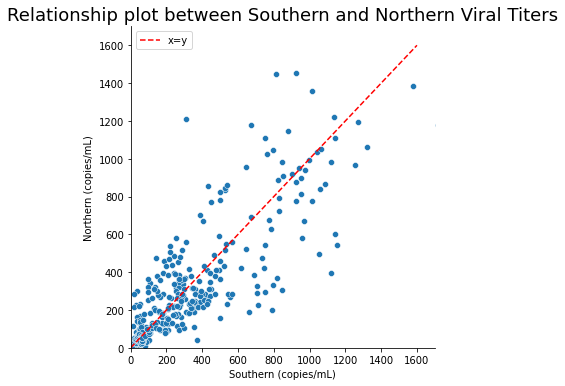

In [52]:
# Show the relation between norther and souther samples
sns.relplot(data=df_mwra, x="Southern (copies/mL)", y="Northern (copies/mL)")
plt.plot([0,1600], [0,1600], '--r', label="x=y")
plt.xlim([0, 1700])
plt.ylim([0, 1700])
plt.legend()
plt.title('Relationship plot between Southern and Northern Viral Titers', fontsize=18, y=1.05)

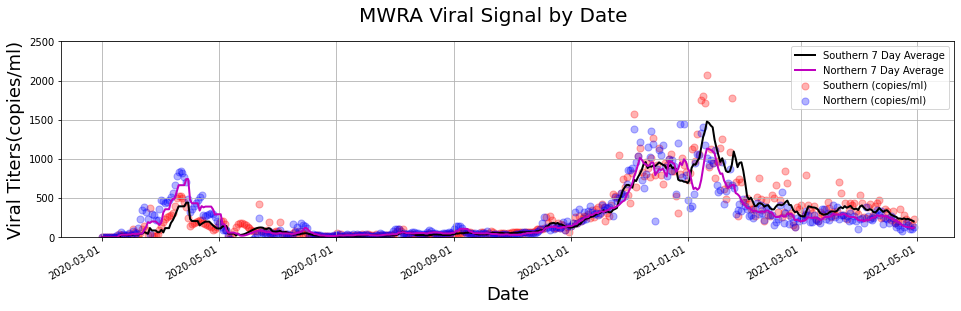

In [53]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.scatter(df_mwra['Date'], df_mwra['Southern (copies/mL)'], color='r', s = 50, alpha=0.3, label="Southern (copies/ml)")
ax.scatter(df_mwra['Date'], df_mwra['Northern (copies/mL)'], color='b', s = 50, alpha=0.3, label="Northern (copies/ml)")
ax.plot(df_mwra['Date'], df_mwra['Southern 7 day avg'], 'k', linewidth = 2,  label="Southern 7 Day Average")
ax.plot(df_mwra['Date'], df_mwra['Northern 7 day avg'], 'm', linewidth = 2, label="Northern 7 Day Average")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 2500])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Viral Titers(copies/ml)', fontsize=18)

fig.autofmt_xdate()
fig.suptitle('MWRA Viral Signal by Date', fontsize=20, y=1.00)
fig.show()

In [54]:
# Load Mass-COVID dataset
df_covid= pd.read_excel(MASS_COVID_DATA_FILE,sheet_name='County_Daily', parse_dates=['Date'])
#display(df_covid.tail(5))

df_covid.rename(columns={"New Confirmed Cases": "Cases", "New Probable and Confirmed Deaths": "Deaths"}, inplace=True)
df_covid.drop(['Total Confirmed Cases', 'Total Probable and Confirmed Deaths'], axis=1, inplace=True)

# Add the old-covid 19 values to the dataset
#MASS_COVID_OLD_DATA_FILE=os.path.join(MASS_COVID_DATA_DIR, "covid-19-raw-data-8-5-2020/County.csv")

#df_covid_2 = pd.read_csv(MASS_COVID_OLD_DATA_FILE, parse_dates=['Date'])
#df_covid_2.rename(columns={"Count": "Cases"}, inplace=True)

# Append the two dataframes
#df_covid = df_covid.append(df_covid_2, ignore_index=True)
# Sort by data and re-index
#df_covid = df_covid.sort_values(by="Date")
#df_covid.reset_index(drop=True, inplace=True)

display(df_covid.tail(10))

,Date,County,Cases,Deaths
3990,2021-04-30,Hampden,128.0,5.0
3991,2021-04-30,Hampshire,13.0,0.0
3992,2021-04-30,Middlesex,237.0,2.0
3993,2021-04-30,Nantucket,4.0,NaN
3994,2021-04-30,Norfolk,99.0,0.0
3995,2021-04-30,Plymouth,97.0,1.0
3996,2021-04-30,Suffolk,135.0,3.0
3997,2021-04-30,Worcester,124.0,0.0
3998,2021-04-30,Unknown,-8.0,0.0
3999,2021-04-30,Dukes and Nantucket,NaN,0.0


In [55]:
df_covid.isna().sum()

Date        0
County      0
Cases     252
Deaths    500
dtype: int64

In [56]:
#Impute missing values
df_covid.interpolate(method="akima", limit_direction='both', inplace=True)
# Fill remaining values with 0
df_covid.fillna(0, inplace=True)
df_covid.isna().sum()

Date      0
County    0
Cases     0
Deaths    0
dtype: int64

In [57]:
# Describe the dataset
df_covid.describe()

,Cases,Deaths
count,4000.000000,4000.000000
mean,134.180520,2.818219
std,205.385985,3.510118
min,-69.000000,-1.000000
25%,8.000000,0.000000
50%,43.330750,2.000000
75%,176.000000,4.000000
max,1607.000000,24.000000


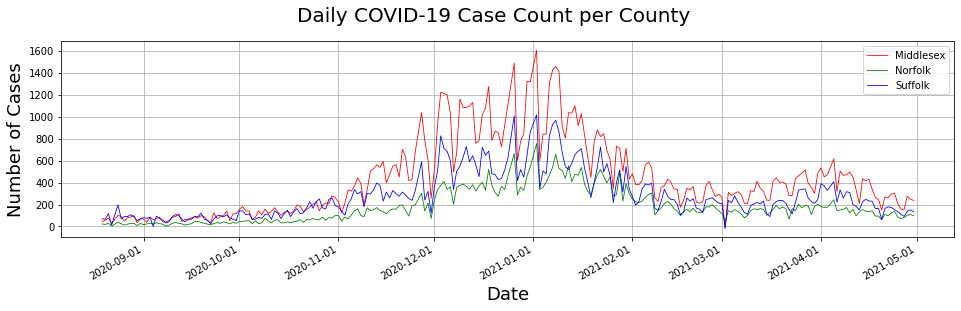

In [58]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

df_ms = df_covid[df_covid['County'].str.contains("Middlesex", case = False)]
df_nr = df_covid[df_covid['County'].str.contains("Norfolk", case = False)]
df_sf = df_covid[df_covid['County'].str.contains("Suffolk", case = False)]

# Plot southern samples
ax.plot(df_ms['Date'], df_ms['Cases'], 'r', linewidth = 0.8, label="Middlesex")
ax.plot(df_ms['Date'], df_nr['Cases'], 'g', linewidth = 0.8, label="Norfolk")
ax.plot(df_ms['Date'], df_sf['Cases'], 'b', linewidth = 0.8, label="Suffolk")


ax.grid(True)
ax.legend()
#ax.set_ylim([0, 2500])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of Cases', fontsize=18)


fig.autofmt_xdate()
fig.suptitle('Daily COVID-19 Case Count per County', fontsize=20, y=1.00)
fig.show()

In [59]:
df_combined = pd.DataFrame(data=None, columns=['Date', 'Cases', 'Deaths'])

allDates = df_covid['Date'].unique()

for i, i_date in enumerate(allDates):
    totalCases = 0
    totalDeaths = 0

    
    # Add middlesex cases
    row = df_ms[df_ms['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]
        
    # Add norfolk cases
    row = df_nr[df_nr['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]

        
    # Add norfolk cases
    row = df_sf[df_sf['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]

        
    df_combined.at[i, 'Date'] = i_date
    df_combined.at[i, 'Cases'] = totalCases
    df_combined.at[i, 'Deaths'] = totalDeaths

df_combined['Date'] = pd.to_datetime(df_combined['Date'])
display(df_combined)

,Date,Cases,Deaths
0,2020-08-19,135,16
1,2020-08-20,142,3
2,2020-08-21,221,3
3,2020-08-22,41,6
4,2020-08-24,340,13
...,...,...,...
245,2021-04-26,339,5
246,2021-04-27,329,1
247,2021-04-28,514,4
248,2021-04-29,507,5


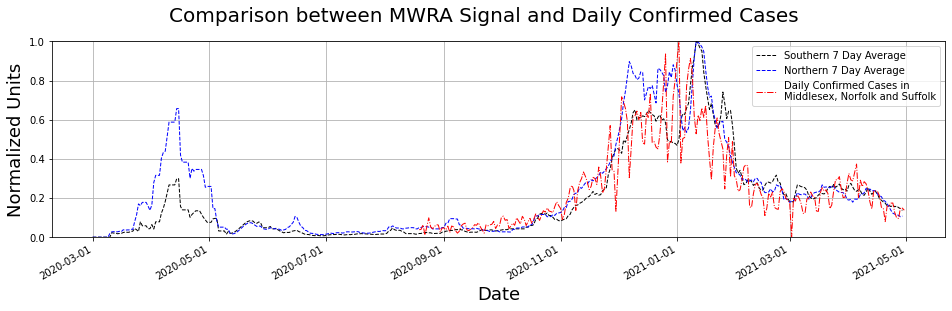

In [60]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_mwra['Date'], normalize(df_mwra['Southern 7 day avg'].to_numpy()), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_mwra['Date'], normalize(df_mwra['Northern 7 day avg'].to_numpy()), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_combined['Date'], normalize(df_combined['Cases'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_combined['Date'], normalize(df_combined['Deaths'].to_numpy()), '-.b', linewidth = 1, label="Daily Confirmed Deaths in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

In [61]:
# Create algined matrix between southern, northen and covid cases
df_aligned = pd.DataFrame(data=None, columns=['Date', 'Southern Raw', 'Northern Raw', 
                                              'Southern Avg', 'Northern Avg', 
                                                'Southern Variant', 'Northern Variant',
                                              'Cases', 'Deaths'])

covidDates = df_covid['Date'].unique()
mwraDates = df_mwra['Date'].unique()
commonDates = np.intersect1d(covidDates, mwraDates)

for i, i_date in enumerate(commonDates):
    total = 0
    
    row = df_mwra[df_mwra['Date'] == i_date]
    if not row.empty:
        df_aligned.at[i, 'Southern Raw'] = row['Southern (copies/mL)'].to_list()[0]
        df_aligned.at[i, 'Northern Raw'] = row['Northern (copies/mL)'].to_list()[0]
        df_aligned.at[i, 'Southern Avg'] = row['Southern 7 day avg'].to_list()[0]
        df_aligned.at[i, 'Northern Avg'] = row['Northern 7 day avg'].to_list()[0]
        df_aligned.at[i, 'Southern Variant'] = row['Southern Variant Results'].to_list()[0]
        df_aligned.at[i, 'Northern Variant'] = row['Northern Variant Results'].to_list()[0]
        
        
    row = df_combined[df_combined['Date'] == i_date]
    if not row.empty:
        df_aligned.at[i, 'Cases'] = row['Cases'].to_list()[0]
        df_aligned.at[i, 'Deaths'] = row['Deaths'].to_list()[0]
        
    df_aligned.at[i, 'Date'] = i_date

# Reformat dates
df_aligned['Date'] = pd.to_datetime(df_aligned['Date'])

In [62]:
# Scale confirmed cases by population per 100,000
MIDDLESEX_POPULATION = 1611699
NORFOLK_POPULATION = 11786
SUFFOLK_POPULATION = 803907
MASS_POPULATION = (MIDDLESEX_POPULATION + NORFOLK_POPULATION + SUFFOLK_POPULATION) / 100000

df_aligned['Cases_per_100K'] = df_aligned['Cases'] / MASS_POPULATION
df_aligned['Deaths_per_100K'] = df_aligned['Deaths'] / MASS_POPULATION

In [63]:
display(df_aligned.head())

,Date,Southern Raw,Northern Raw,Southern Avg,Northern Avg,Southern Variant,Northern Variant,Cases,Deaths,Cases_per_100K,Deaths_per_100K
0,2020-08-19,50,87,28,56,0,0,135,16,5.56152,0.659144
1,2020-08-20,43.0683,74.2871,28,56,0,0,142,3,5.8499,0.123589
2,2020-08-21,35,60,35,61,0,0,221,3,9.10442,0.123589
3,2020-08-22,28.5253,49.5942,35,61,0,0,41,6,1.68906,0.247179
4,2020-08-24,21,38,33,58,0,0,340,13,14.0068,0.535554


Text(0.5, 1.05, 'Relationship plot between Southern Titers and New Confirmed Cases')

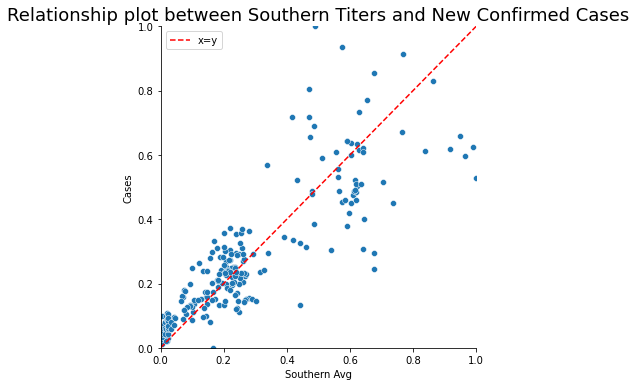

In [64]:
# Scale the values
df_scaled = df_aligned.copy()
scaler = MinMaxScaler()
df_scaled[['Southern Raw', 'Northern Raw','Southern Avg', 'Northern Avg','Cases', 'Deaths']] = scaler.fit_transform(df_aligned[['Southern Raw', 'Northern Raw', 
                                                                                                                    'Southern Avg', 'Northern Avg',
                                                                                                                           'Cases_per_100K', 'Deaths_per_100K']])
# Show the relation between norther and souther samples
sns.relplot(data=df_scaled, x="Southern Avg", y="Cases")
plt.plot([0,1], [0,1], '--r', label="x=y")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.title('Relationship plot between Southern Titers and New Confirmed Cases', fontsize=18, y=1.05)

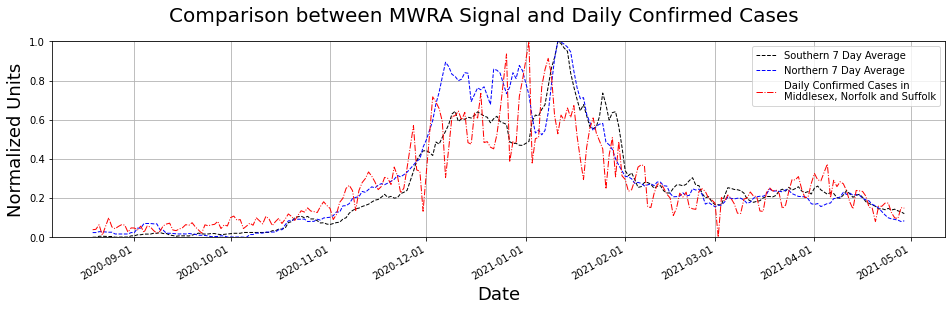

In [65]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_aligned['Date'], normalize(df_aligned['Southern Avg'].to_numpy()), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Northern Avg'].to_numpy()), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Cases'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

In [66]:
# Compute 7 day moving average for cases and deaths
df_aligned['Cases Avg'] = df_aligned['Cases'].rolling(window=7).mean()
df_aligned['Deaths Avg'] = df_aligned['Deaths'].rolling(window=7).mean()

# Interpolate head
df_aligned.interpolate(limit_direction="both", inplace=True)

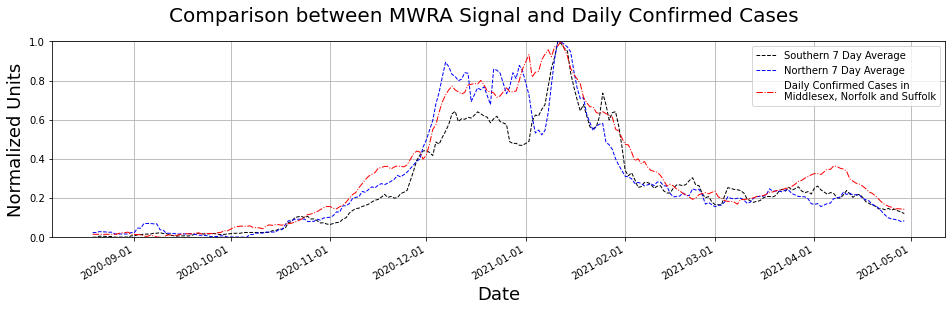

In [67]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_aligned['Date'], normalize(df_aligned['Southern Avg'].to_numpy()), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Northern Avg'].to_numpy()), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Cases Avg'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

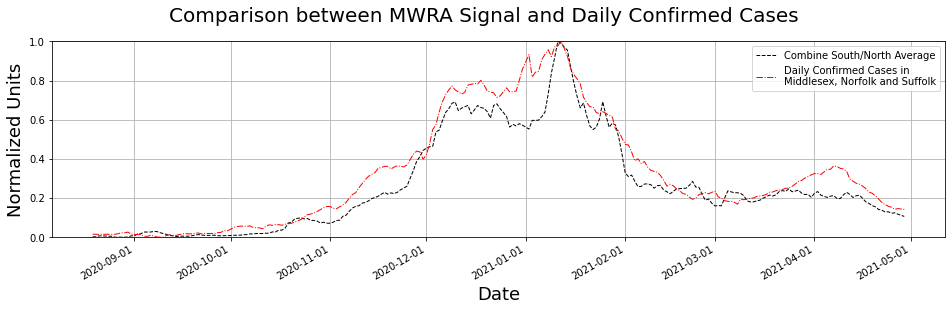

In [68]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
sn_combine = df_aligned['Southern Avg'] + df_aligned['Northern Avg'] / 2
ax.plot(df_aligned['Date'], normalize(sn_combine.to_numpy()), '--k', linewidth = 1,  label="Combine South/North Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Cases Avg'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

# Modeling


In [69]:
# Split Dataset into train and test
TRAIN_PERCENTAGE = 0.7;
train_size = int(len(df_aligned) * TRAIN_PERCENTAGE)

df_train, df_test = np.split(df_aligned, [int(TRAIN_PERCENTAGE*len(df_aligned))])
print('Train Size: {}'.format(len(df_train)))
print('Test Size: {}'.format(len(df_test)))

Train Size: 174
Test Size: 75


# Persistence Model

In [136]:
# Create lagged dataset
def persistence_values(x):
    x = pd.DataFrame(x)
    df = pd.concat([x.shift(1), x], axis=1)
    df.columns = ['x', 'y']
    return df

train = persistence_values(df_train['Cases'])
test = persistence_values(df_test['Cases'])

train_X, train_y = train.iloc[:,0], train.iloc[:,1]
test_X, test_y = test.iloc[:,0], test.iloc[:,1]

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = [ model_persistence(x) for x in test_X ]
test_score = mean_squared_error(test_y[1:], predictions[1:])
print('Test MSE: %.3f' % test_score)

Test MSE: 37707.865


In [137]:
np.asarray(test_y[1:].values)

array([747.0, 683.0, 379.0, 504.0, 765.0, 699.0, 783.0, 521.0, 496.0,
       486.0, 795.0, 842.0, 793.0, 675.0, 647.0, 593.0, 6.0, 691.0, 629.0,
       734.0, 674.0, 582.0, 419.0, 416.0, 662.0, 683.0, 785.0, 714.0,
       708.0, 458.0, 451.0, 770.0, 859.0, 802.0, 821.0, 759.0, 499.0,
       560.0, 796.0, 997.0, 993.0, 1051.0, 839.0, 688.0, 697.0, 933.0,
       1105.0, 995.0, 977.0, 1267.0, 687.0, 988.0, 878.0, 963.0, 927.0,
       807.0, 614.0, 494.0, 812.0, 805.0, 795.0, 715.0, 523.0, 507.0,
       275.0, 542.0, 539.0, 593.0, 595.0, 429.0, 339.0, 329.0, 514.0,
       507.0], dtype=object)

In [140]:
#!rm validation_results.csv

In [141]:
execute_all_validations('persistence',np.asarray(test_y[1:].values),predictions[1:])
#extFunc(df_test['Cases_Avg'].values,test_preds['mean'].values)
!more validation_results.csv

136.75675675675674
37707.86486486487
persistence,2021:05:05,mae_calc,136.75675675675674
persistence,2021:05:05,rmse_calc,37707.86486486487


In [143]:
# Linear Regression Model
X = df_train[['Southern Raw', 'Northern Raw']].astype('float')
y = df_train['Cases'].astype('float')

X = sm.add_constant(X) # adding a constant
model_lm1 = sm.OLS(y, X).fit()

# Print summary
model_lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     245.6
Date:                Wed, 05 May 2021   Prob (F-statistic):           5.30e-51
Time:                        23:27:02   Log-Likelihood:                -1293.5
No. Observations:                 174   AIC:                             2593.
Df Residuals:                     171   BIC:                             2603.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          244.3242     45.516      5.368      0.000     154.479     334.170
Southern Raw     0.3476      0.096      3.623      0.000       0.158       0.537
Northern Raw     1.3942      0.124     11.210      0.000       1.149       1.640
==============================================================================
Omnibus:                       81.646   Durbin-Watson:                   1.541
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              605.207
Skew:                           1.545   Prob(JB):                    3.81e-132
Kurtosis:                      11.598   Cond. No.                     1.26e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Multiple Linear Regression

In [158]:
train_preds = model_lm1.get_prediction(X).summary_frame()

X_test = df_test[['Southern Raw', 'Northern Raw']].astype('float')
X_test = sm.add_constant(X_test) # adding a constant
test_preds = model_lm1.get_prediction(X_test).summary_frame()

array([ 827.6526823 ,  634.24493078,  739.70695261,  681.11093582,
        984.21478955, 1140.56887692,  608.61913521,  968.53674134,
       1021.3162168 ,  568.57129355,  713.19623743,  568.68151607,
        464.13748061,  716.95776386,  662.26148579,  736.45472095,
        642.12436981,  734.47178483,  984.26849791,  789.42751996,
        631.59244309,  617.34307894,  778.98744535,  628.91056273,
        605.93358077,  615.58285904,  856.1087245 ,  849.16337109,
        697.80844186,  831.92350352,  675.48998921,  705.5703102 ,
        936.94744108,  703.11114606,  894.41471669,  807.6317341 ,
        839.83093231,  742.84074531,  735.73740629,  694.09835259,
        653.91089573,  831.93452577,  689.40274053,  782.43440346,
        656.35536354,  497.79562383,  756.20378693,  738.17452593,
        582.87576896,  760.52237124,  716.92102302,  644.5725117 ,
        687.4234785 ,  798.86143019,  884.21205462,  808.19981422,
        799.69631554,  569.29228229,  702.69370338,  689.47254

In [163]:
execute_all_validations('liner',np.asarray(test_y[1:].values),test_preds['mean'][1:].values)
#extFunc(df_test['Cases_Avg'].values,test_preds['mean'].values)
!more validation_results.csv

174.31886195952865
51668.88303175306
persistence,2021:05:05,mae_calc,136.75675675675674
persistence,2021:05:05,rmse_calc,37707.86486486487
liner,2021:05:05,mae_calc,174.31886195952865
liner,2021:05:05,rmse_calc,51668.88303175306


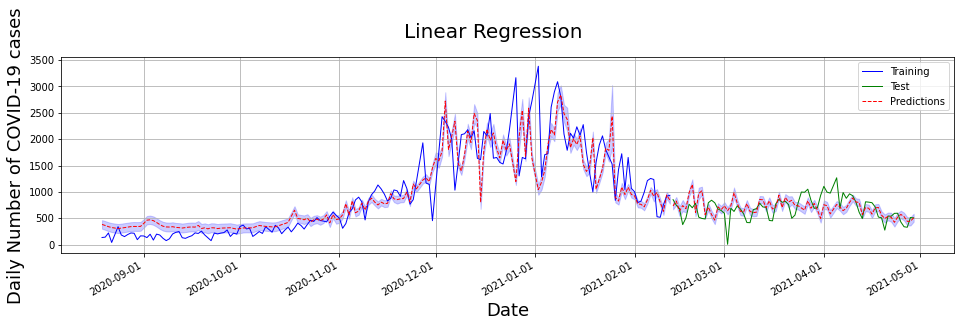

In [164]:
# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'], train_y, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'], test_y, 'g', linewidth = 1,  label="Test")
ax.plot(df_train['Date'], train_preds['mean'], '--r', linewidth = 1)
ax.plot(df_test['Date'], test_preds['mean'], '--r', linewidth = 1,  label="Predictions")

# CI for the predection at each x value, i.e. the line itself
ax.fill_between(df_train['Date'], train_preds['mean_ci_lower'], 
                train_preds['mean_ci_upper'], color='b', alpha=.2)

ax.fill_between(df_test['Date'], test_preds['mean_ci_lower'], 
                test_preds['mean_ci_upper'], color='b', alpha=.2)
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Daily Number of COVID-19 cases', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Linear Regression', fontsize=20, y=1.00)
fig.show()

# Polynomal Regression

In [167]:
def generate_poly_features(x, degree):
    poly = PolynomialFeatures(degree=degree)
    xp = poly.fit_transform(x)
    return xp

def generate_polynomial_model(x, y, degree):
    xp = generate_poly_features(x, degree)
    return xp, sm.OLS(y, xp).fit()

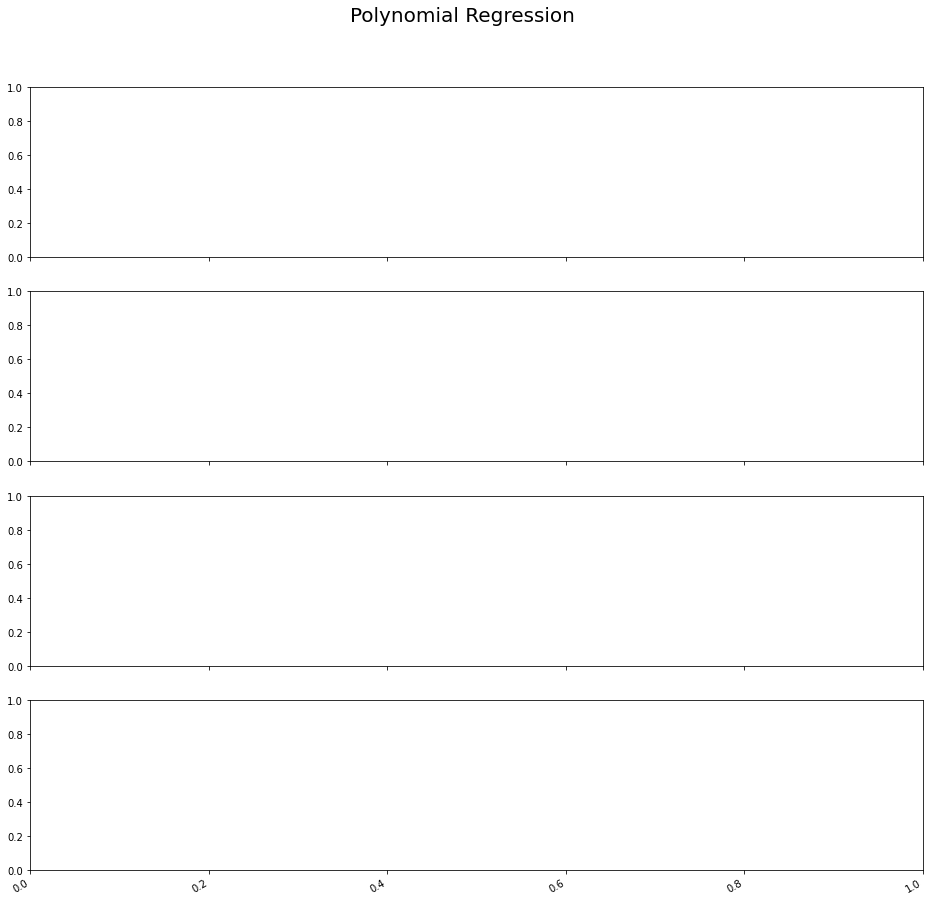

In [168]:
#your code here
poly_models = list()
degrees = [2,3,5,8]

# plot predictions and expected results
fig, ax = plt.subplots(nrows = 4, ncols = 1, sharey=True, figsize=(16,16))
ax = ax.flatten()

X = df_train[['Southern Raw', 'Northern Raw']].astype('float')
y = df_train['Cases'].astype('float')
    
for i, (model, degree) in enumerate(zip(poly_models, degrees)):

    # Generate model
    X_train , model = generate_polynomial_model(X, y, degree)
    
    # Add model to list
    poly_models.append(model)
    
    # Generate x_test
    X_test = generate_poly_features(df_test[['Southern Raw', 'Northern Raw']].astype('float'), degree)
    
    # Generate predictions
    train_preds = model.get_prediction(X_train).summary_frame()
    test_preds = model.get_prediction(X_test).summary_frame()
    
    ax[i].plot(df_train['Date'], train_y, 'b', linewidth = 1,  label="Training")
    ax[i].plot(df_test['Date'], test_y, 'g', linewidth = 1,  label="Test")
    ax[i].plot(df_train['Date'], train_preds['mean'], '--r', linewidth = 1)
    ax[i].plot(df_test['Date'], test_preds['mean'], '--r', linewidth = 1,  label="Predictions")

    # CI for the predection at each x value, i.e. the line itself
    ax[i].fill_between(df_train['Date'], train_preds['mean_ci_lower'], 
                    train_preds['mean_ci_upper'], color='b', alpha=.2)

    ax[i].fill_between(df_test['Date'], test_preds['mean_ci_lower'], 
                    test_preds['mean_ci_upper'], color='b', alpha=.2)

    ax[i].grid(True)
    ax[i].legend()
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[i].set_title(f'Degree: {degree}', fontsize=14)
    ax[i].set_ylabel(f'Daily Cases', fontsize = 18)
    ax[i].set_xlabel('Date', fontsize = 18)

    
fig.autofmt_xdate()
fig.suptitle('Polynomial Regression', fontsize=20, y=0.95)
fig.show()

# RNN Models

In [169]:
X_train = X
y_train = y

X_test = df_test[['Southern Raw', 'Northern Raw']].astype('float')
y_test = df_test['Cases'].astype('float')

In [170]:
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler on training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(np.array(y_train).reshape(-1, 1))

# Transform training data
train_y_norm = output_scaler.transform(np.array(y_train).reshape(-1, 1))
train_x_norm = input_scaler.transform(X_train)

# Transform test data
test_y_norm = output_scaler.transform(np.array(y_test).reshape(-1, 1))
test_x_norm = input_scaler.transform(X_test)

In [171]:
# GRUs and LSTMs expect a 3D input

def convert_dataset_3d (X, y, time_steps=1):
    X_values, y_values = [], []
    for i in range(len(X) - time_steps):
        X_values.append(X[i: i+time_steps, :])
        y_values.append(y[i+time_steps])
    return np.array(X_values), np.array(y_values)

TIME_STEPS = 14

X_train, y_train = convert_dataset_3d(train_x_norm, train_y_norm, TIME_STEPS)
X_test, y_test = convert_dataset_3d(test_x_norm, test_y_norm, TIME_STEPS)


print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (160, 14, 2)
y_train.shape:  (160, 1)
X_test.shape:  (61, 14, 2)
y_test.shape:  (61, 1)


In [172]:
n_units = 256
drop_rate = 0.1
batch_size = 32
epochs = 50
validation_split = 0.2
verbose = 0

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

In [173]:
# Define GRU Model
model_gru = Sequential()
model_gru.add(GRU(n_units, return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]]))
model_gru.add(tf.keras.layers.Dropout(drop_rate))
model_gru.add(GRU(n_units))
model_gru.add(Dense(1, activation='linear'))

# Compile model
model_gru.compile(optimizer='adam', loss='mse')

print(model_gru.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 14, 256)           199680    
_________________________________________________________________
dropout (Dropout)            (None, 14, 256)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               394752    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 594,689
Trainable params: 594,689
Non-trainable params: 0
_________________________________________________________________
None


In [174]:
# Define LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(n_units, return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]]))
model_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_lstm.add(LSTM(n_units))
model_lstm.add(Dense(1, activation='linear'))

# Compile model
model_lstm.compile(optimizer='adam', loss='mse')

print(model_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 256)           265216    
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 790,785
Trainable params: 790,785
Non-trainable params: 0
_________________________________________________________________
None


In [175]:
# Define Bidirectional GRU Model
model_bi_gru = Sequential()
model_bi_gru.add(Input([X_train.shape[1], X_train.shape[2]]))
model_bi_gru.add(Bidirectional(GRU(n_units, return_sequences = True)))
model_bi_gru.add(tf.keras.layers.Dropout(drop_rate))
model_bi_gru.add(Bidirectional(GRU(n_units)))
model_bi_gru.add(Dense(1, activation='linear'))

# Compile model
model_bi_gru.compile(optimizer='adam', loss='mse')

print(model_bi_gru.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 14, 512)           399360    
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1182720   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 1,582,593
Trainable params: 1,582,593
Non-trainable params: 0
_________________________________________________________________
None


In [176]:
# Define Bidirectional LSTM Model
model_bi_lstm = Sequential()
model_bi_lstm.add(Input([X_train.shape[1], X_train.shape[2]]))
model_bi_lstm.add(Bidirectional(LSTM(n_units, return_sequences = True)))
model_bi_lstm.add(tf.keras.layers.Dropout(drop_rate))
model_bi_lstm.add(Bidirectional(LSTM(n_units)))
model_bi_lstm.add(Dense(1, activation='linear'))

# Compile model
model_bi_lstm.compile(optimizer='adam', loss='mse')

print(model_bi_lstm.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 14, 512)           530432    
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 512)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 2,105,857
Trainable params: 2,105,857
Non-trainable params: 0
_________________________________________________________________
None


In [177]:
# Train model
history_gru = model_gru.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

history_lstm = model_lstm.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

history_bi_gru = model_bi_gru.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

history_bi_lstm = model_bi_lstm.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose, callbacks = [early_stop])

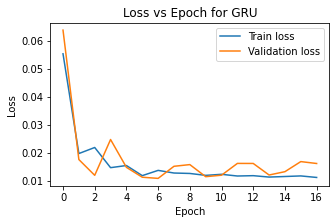

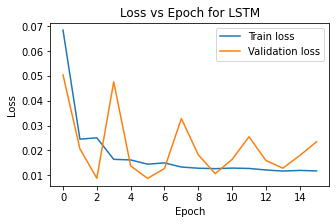

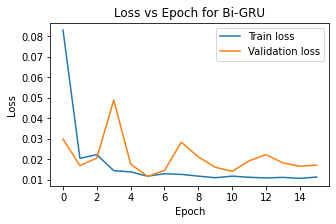

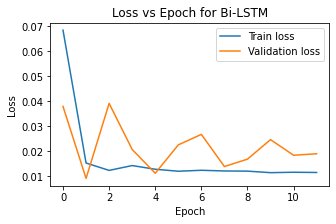

In [178]:
# Plot train loss and validation loss
def plot_loss(history, name):
    plt.figure(figsize = (5, 3))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title(f"Loss vs Epoch for {name}")
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss(history_gru, "GRU")
plot_loss(history_lstm, "LSTM")
plot_loss(history_bi_gru, "Bi-GRU")
plot_loss(history_bi_lstm, "Bi-LSTM")

In [179]:
# Inverse transform the target variable
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [180]:
# Generate Predictions
def prediction(model, X):
    prediction = scaler_y.inverse_transform(model.predict(X))
    return prediction

train_prediction_gru = prediction(model_gru, X_train)
train_prediction_lstm = prediction(model_lstm, X_train)
train_prediction_bi_gru = prediction(model_bi_gru, X_train)
train_prediction_bi_lstm = prediction(model_bi_lstm, X_train)

prediction_gru = prediction(model_gru, X_test)
prediction_lstm = prediction(model_lstm, X_test)
prediction_bi_gru = prediction(model_bi_gru, X_test)
prediction_bi_lstm = prediction(model_bi_lstm, X_test)

In [191]:
execute_all_validations('gru',np.asarray(y_train[1:]),train_prediction_gru[1:,0])
execute_all_validations('lstm',np.asarray(y_train[1:]),train_prediction_lstm[1:,0])
execute_all_validations('bi_gru',np.asarray(y_train[1:]),train_prediction_bi_gru[1:,0])
execute_all_validations('bi_lstm',np.asarray(y_train[1:]),train_prediction_bi_lstm[1:,0])
!more validation_results.csv

255.51932482449513
137840.02764265763
280.1158190073457
159901.4095418361
259.07324161169663
136968.34949688218
264.30594946903256
144081.20158393495
persistence,2021:05:05,mae_calc,136.75675675675674
persistence,2021:05:05,rmse_calc,37707.86486486487
liner,2021:05:05,mae_calc,174.31886195952865
liner,2021:05:05,rmse_calc,51668.88303175306
gru,2021:05:05,mae_calc,255.51932482449513
gru,2021:05:05,rmse_calc,137840.02764265763
gru,2021:05:05,mae_calc,255.51932482449513
gru,2021:05:05,rmse_calc,137840.02764265763
lstm,2021:05:05,mae_calc,280.1158190073457
lstm,2021:05:05,rmse_calc,159901.4095418361
bi_gru,2021:05:05,mae_calc,259.07324161169663
bi_gru,2021:05:05,rmse_calc,136968.34949688218
bi_lstm,2021:05:05,mae_calc,264.30594946903256
bi_lstm,2021:05:05,rmse_calc,144081.20158393495


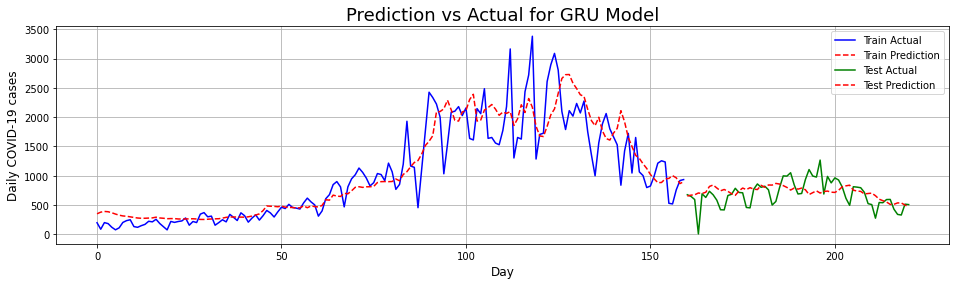

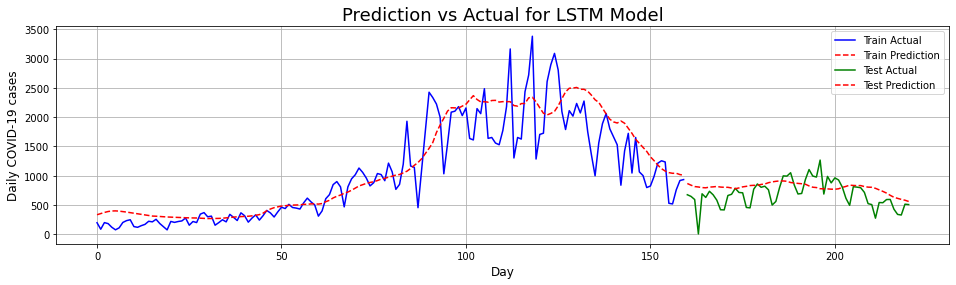

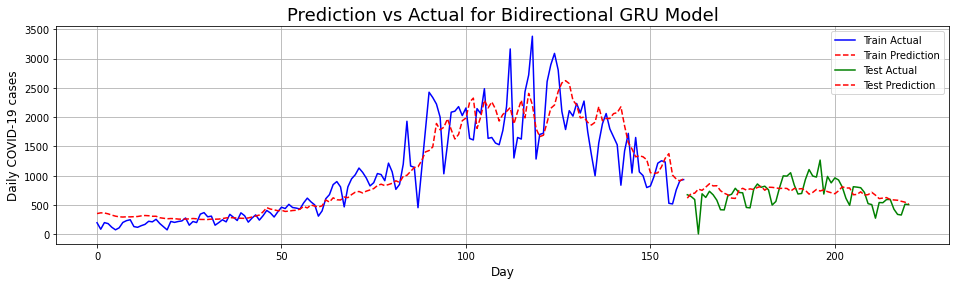

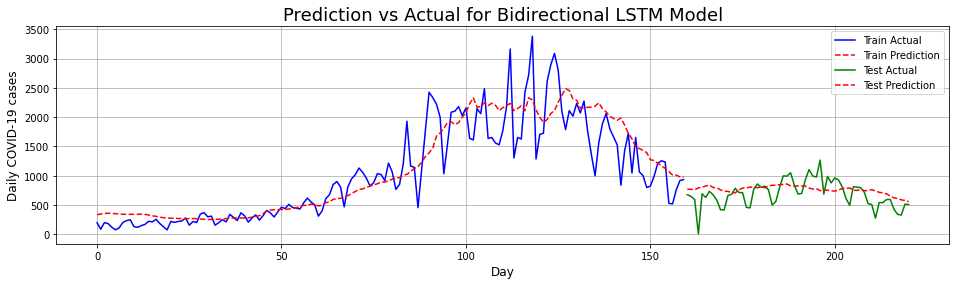

In [181]:
def plot_prediction(train_pred, test_pred, model):

    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

    train_range = len(train_pred)
    test_range = train_range + len(test_pred)

    plt.plot(np.arange(train_range), np.array(y_train), 'b', label='Train Actual')     
    plt.plot(np.arange(train_range),np.array(train_pred), '--r', label='Train Prediction')
    plt.plot(np.arange(train_range, test_range), np.array(y_test), 'g', label='Test Actual')     
    plt.plot(np.arange(train_range, test_range),np.array(test_pred), '--r', label='Test Prediction')
    
    plt.legend()
    plt.grid(True)
    plt.ylabel('Daily COVID-19 cases', fontsize = 12)
    plt.xlabel('Day', fontsize = 12)
    plt.title(f"Prediction vs Actual for {model} Model", fontsize = 18)
    plt.show()
    
plot_prediction(train_prediction_gru, prediction_gru, "GRU")
plot_prediction(train_prediction_lstm, prediction_lstm, "LSTM")
plot_prediction(train_prediction_bi_gru, prediction_bi_gru, "Bidirectional GRU")
plot_prediction(train_prediction_bi_lstm, prediction_bi_lstm, "Bidirectional LSTM")

In [ ]:
# Calculate RMSE
def rmse_calc(predictions, actual, name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    print(f"{name} Model:")
    print('Root Mean Square Error: {:.2f}'.format(rmse))
    print("\n")
    
rmse_calc(prediction_gru, y_test, "GRU")
rmse_calc(prediction_lstm, y_test, "LSTM")
rmse_calc(prediction_bi_gru, y_test, "Bi-GRU")
rmse_calc(prediction_bi_lstm, y_test, "Bi-LSTM")

GRU Model:
Root Mean Square Error: 216.74


LSTM Model:
Root Mean Square Error: 216.97


Bi-GRU Model:
Root Mean Square Error: 221.42


Bi-LSTM Model:
Root Mean Square Error: 227.15




# Best Model

In [193]:
val_df = pd.read_csv('validation_results.csv',names=['model_name','date','metrix','value'])
val_df.head()

,model_name,date,metrix,value
0,persistence,2021:05:05,mae_calc,136.756757
1,persistence,2021:05:05,rmse_calc,37707.864865
2,liner,2021:05:05,mae_calc,174.318862
3,liner,2021:05:05,rmse_calc,51668.883032
4,gru,2021:05:05,mae_calc,255.519325


In [195]:
val_df.sort_values(by = ['metrix','value'])

,model_name,date,metrix,value
0,persistence,2021:05:05,mae_calc,136.756757
2,liner,2021:05:05,mae_calc,174.318862
4,gru,2021:05:05,mae_calc,255.519325
6,gru,2021:05:05,mae_calc,255.519325
10,bi_gru,2021:05:05,mae_calc,259.073242
12,bi_lstm,2021:05:05,mae_calc,264.305949
8,lstm,2021:05:05,mae_calc,280.115819
1,persistence,2021:05:05,rmse_calc,37707.864865
3,liner,2021:05:05,rmse_calc,51668.883032
11,bi_gru,2021:05:05,rmse_calc,136968.349497
